In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jcopml.plot import plot_missing_value #untuk plot missing value
from sklearn.model_selection import train_test_split #untuk dataset splitting

#library untuk preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier, plot_importance, plot_tree #untuk pemodelan dan plotting

#library untuk model training
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.utils import Integer, Real
from jcopml.tuning.space import Integer as JInteger, Real as JReal

from jcopml.utils import save_model #save model


# Import Data

In [2]:
#Import Data
df=pd.read_csv("german_credit_data.csv",sep=',', index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [3]:
df.rename(columns={'Risk':'target'}, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving_accounts   817 non-null    object
 5   Checking_account  606 non-null    object
 6   Credit_amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   target            1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 85.9+ KB


In [5]:
print(df.nunique())

Age                  53
Sex                   2
Job                   4
Housing               3
Saving_accounts       4
Checking_account      3
Credit_amount       921
Duration             33
Purpose               8
target                2
dtype: int64


In [6]:
df['target']=pd.Categorical(df.target)
df['Job']=pd.Categorical(df.Job)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   object  
 2   Job               1000 non-null   category
 3   Housing           1000 non-null   object  
 4   Saving_accounts   817 non-null    object  
 5   Checking_account  606 non-null    object  
 6   Credit_amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   object  
 9   target            1000 non-null   category
dtypes: category(2), int64(3), object(5)
memory usage: 72.6+ KB


In [7]:
df.describe()

,Age,Credit_amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


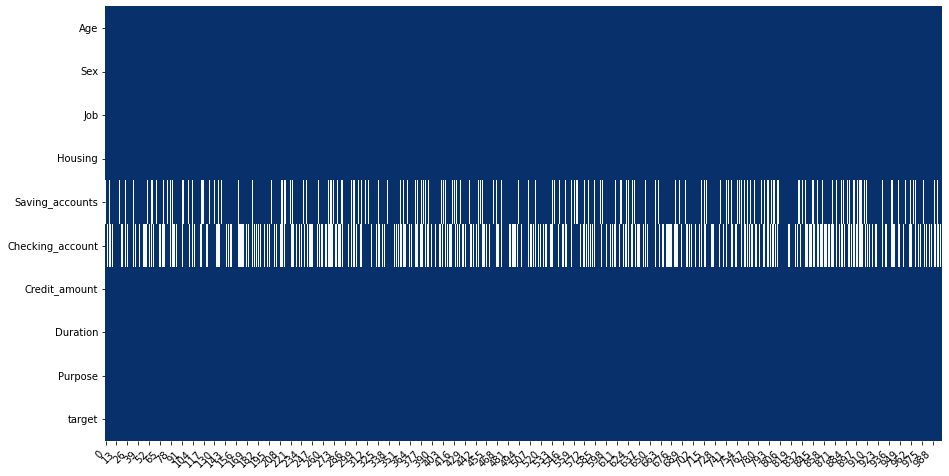

In [8]:
plot_missing_value(df)

0    700
1    300
Name: target, dtype: int64

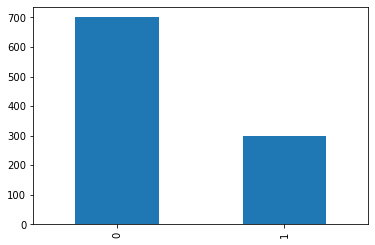

In [9]:
df.target.value_counts().plot(kind="bar")
df.target.value_counts()

# Dataset Splitting

In [10]:
# dataset splitting
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 9), (200, 9), (800,), (200,))

# Step 1: Data Preprocessing

In [11]:
num_data=X_train.select_dtypes(include=[np.number])
cat_data=X_train.select_dtypes(exclude=[np.number])
num_columns=num_data.columns
cat_columns=cat_data.columns

# Preprocessor
numerical_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor=ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, num_columns),
    ('categoric', categorical_pipeline, cat_columns)
])

In [12]:
#Pipeline Default 
pipeline_d=Pipeline([
    ('prepo', preprocessor),
    ('algo', XGBClassifier(random_state=23))
])

In [13]:
#Pipeline 
ratio=float((np.sum(df.target == 0)) / (np.sum(df.target ==1)))
pipeline=Pipeline([
    ('prepo', preprocessor),
    ('algo', XGBClassifier(random_state=23, scale_pos_weight=ratio))
])

# Step 2: Model Training

In [14]:
## Model Default 
# Waktu Running
start = time.time()
columns_names=X_train.columns
model_d=pipeline_d.fit(X_train, y_train)
end = time.time() 

waktu_md=end-start
print(f"Best Score : {cross_val_score(model_d,X_train, y_train, scoring='f1', cv=3).mean(), cross_val_score(model_d,X_test, y_test,scoring='f1', cv=3).mean()}")
print(f"Waktu Running : {waktu_md}")

#Fitting Model
y_pred_md=model_d.predict(X_test)
cm_md=confusion_matrix(y_test, y_pred_md)
print(f"\n Confussion Matrix Model Default:\n {cm_md}")

# Performa Model
tn, fp, fn, tp=cm_md.ravel()
accuracy_md=(tn+tp)/(tn+fp+fn+tp)
sensitivity_md=tp/(tp+fn)
precition_md=tp/(tp+fp)
specificity_md=tn/(tn+fp)
f1score_md=2*tp/(2*tp+fp+fn)
print("\n Performa Model Default")
print("Accuracy :", accuracy_md)
print("Sensitivity :", sensitivity_md)
print("Precition :", precition_md)
print("Specificity :", specificity_md)
print("F1 Score :", f1score_md)

Best Score : (0.33545020870602266, 0.2967432950191571)
Waktu Running : 0.16353678703308105

 Confussion Matrix Model Default:
 [[126  14]
 [ 46  14]]

 Performa Model Default
Accuracy : 0.7
Sensitivity : 0.23333333333333334
Precition : 0.5
Specificity : 0.9
F1 Score : 0.3181818181818182


### GridSearchCV

In [69]:
grid_params={
    'algo__max_depth': [4, 5, 6],
    'algo__colsample_bytree': [0.9, 1.0],
    'algo__n_estimators': [100, 150, 200],
    'algo__subsample': [0.9, 1.0],
    'algo__gamma': [0.1, 1.0],
    'algo__learning_rate': [0.01, 0.1, 0.2],
    'algo__min_child_weight': [0.0, 2.0]
}

In [70]:
## Model GSCV 
#Waktu Penyetelan
start=time.time()
model_gsCV = GridSearchCV(pipeline, grid_params, cv=3,scoring='f1', verbose=1, n_jobs=-1)
model_gsCV.fit(X_train, y_train)
end=time.time()

waktu_mg=end-start
print(f"Best Parameter: {model_gsCV.best_params_}")
print(f" Score Train dan Test: {model_gsCV.score(X_train, y_train), model_gsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mg}")

#Fitting Model
y_pred_mg=model_gsCV.predict(X_test)
cm_mg=confusion_matrix(y_test, y_pred_mg)
print(f"\n Confussion Matrix Model Grid Search:\n {cm_mg}")

# Performa Model
tn, fp, fn, tp=cm_mg.ravel()
accuracy_mg=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mg=tp/(tp+fn)
precition_mg=tp/(tp+fp)
specificity_mg=tn/(tn+fp)
f1score_mg=2*tp/(2*tp+fp+fn)
print("\n Performa Model Grid Search")
print("Accuracy :", accuracy_mg)
print("Sensitivity :", sensitivity_mg)
print("Precition :", precition_mg)
print("Specificity :", specificity_mg)
print("F1 Score :", f1score_mg)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameter: {'algo__colsample_bytree': 1.0, 'algo__gamma': 0.1, 'algo__learning_rate': 0.1, 'algo__max_depth': 6, 'algo__min_child_weight': 0.0, 'algo__n_estimators': 200, 'algo__subsample': 1.0}
 Score Train dan Test: (0.998158379373849, 0.7765567765567766)
Waktu Running : 187.81128931045532

 Confussion Matrix Model Grid Search:
 [[485  31]
 [ 30 106]]

 Performa Model Grid Search
Accuracy : 0.906441717791411
Sensitivity : 0.7794117647058824
Precition : 0.7737226277372263
Specificity : 0.939922480620155
F1 Score : 0.7765567765567766


### RandomizedSearchCV

In [44]:
random_params={
    'algo__max_depth': JInteger(low=3, high=15),
    'algo__learning_rate': JReal(low=0.01, high=0.2, prior='uniform'),
    'algo__n_estimators': JInteger(low=80, high=200),
    'algo__subsample': JReal(low=0.5, high=1.0, prior='uniform'),
    'algo__gamma': JReal(low=0.0, high=1.0, prior='uniform'),
    'algo__colsample_bytree': JReal(low=0.8, high=1.0, prior='uniform'),
    'algo__min_child_weight': JReal(low=0.0, high=5.0, prior='uniform')
} 

In [45]:
## Model RSCV 
# Waktu Penyetelan
start=time.time()
model_rsCV = RandomizedSearchCV(pipeline, random_params,scoring='f1', cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_rsCV.fit(X_train, y_train)
end=time.time()

waktu_mr=end-start
print(f"Best Parameter: {model_rsCV.best_params_}")
print(f" Score Train dan Test: {model_rsCV.score(X_train, y_train), model_rsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mr}")

#Fitting Model
y_pred_mr=model_rsCV.predict(X_test)
cm_mr=confusion_matrix(y_test, y_pred_mr)
print(f"\n Confussion Matrix Model Random Search:\n {cm_mr}")

# Performa Model
tn, fp, fn, tp=cm_mr.ravel()
accuracy_mr=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mr=tp/(tp+fn)
precition_mr=tp/(tp+fp)
specificity_mr=tn/(tn+fp)
f1score_mr=2*tp/(2*tp+fp+fn)
print("\n Performa Model Random Search")
print("Accuracy :", accuracy_mr)
print("Sensitivity :", sensitivity_mr)
print("Precition :", precition_mr)
print("Specificity :", specificity_mr)
print("F1 Score :", f1score_mr)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameter: {'algo__colsample_bytree': 0.9105639953815816, 'algo__gamma': 0.29651014364779854, 'algo__learning_rate': 0.08975836272479254, 'algo__max_depth': 4, 'algo__min_child_weight': 4.33536159290052, 'algo__n_estimators': 92, 'algo__subsample': 0.5407970902001202}
 Score Train dan Test: (0.7158273381294965, 0.5035971223021583)
Waktu Running : 11.339328289031982

 Confussion Matrix Model Random Search:
 [[96 44]
 [25 35]]

 Performa Model Random Search
Accuracy : 0.655
Sensitivity : 0.5833333333333334
Precition : 0.4430379746835443
Specificity : 0.6857142857142857
F1 Score : 0.5035971223021583


### BayesianSearchCV

In [15]:
bayes_params={
    'algo__max_depth': Integer(low=3, high=10),
    'algo__learning_rate': Real(low=0.01, high=0.3, prior='uniform'),
    'algo__n_estimators': Integer(low=60, high=180),
    'algo__subsample': Real(low=0.9, high=1.0, prior='uniform'),
    'algo__gamma': Real(low=0.01, high=0.1, prior='uniform'),
    'algo__colsample_bytree': Real(low=0.9, high=1.0, prior='uniform'),
    'algo__min_child_weight': Real(low=0.0, high=5.0, prior='uniform')
}

In [16]:
## Model BSCV
# Waktu Penyetelan
start=time.time()
model_bsCV = BayesSearchCV(pipeline, bayes_params, optimizer_kwargs={'n_initial_points': 5, 'acq_func': 'EI'}, cv=3,scoring='f1', verbose=1, n_iter=50, n_jobs=-1, random_state=23)
model_bsCV.fit(X_train, y_train)
end=time.time()

waktu_mb=end-start
print(f"Best Parameter: {model_bsCV.best_params_}")
print(f" Score Train dan Test: {model_bsCV.score(X_train, y_train), model_bsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mb}")

#Fitting Model
y_pred_mb=model_bsCV.predict(X_test)
cm_mb=confusion_matrix(y_test, y_pred_mb)
print(f"\n Confussion Matrix Model Bayesian Search:\n {cm_mb}")

# Performa Model
tn, fp, fn, tp=cm_mb.ravel()
accuracy_mb=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mb=tp/(tp+fn)
precition_mb=tp/(tp+fp)
specificity_mb=tn/(tn+fp)
f1score_mb=2*tp/(2*tp+fp+fn)
print("\n Performa Model Bayesian Search")
print("Accuracy :", accuracy_mb)
print("Sensitivity :", sensitivity_mb)
print("Precition :", precition_mb)
print("Specificity :", specificity_mb)
print("F1 Score :", f1score_mb)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

# Step 3: Evaluasi

In [71]:
acc= [accuracy_md, accuracy_mg, accuracy_mr, accuracy_mb] 
sens=[sensitivity_md, sensitivity_mg, sensitivity_mr,sensitivity_mb]
prec=[precition_md, precition_mg,  precition_mr,  precition_mb]
spec=[specificity_md,  specificity_mg, specificity_mr,  specificity_mb]
f1s=[f1score_md,  f1score_mg,  f1score_mr, f1score_mb]
wkt=[waktu_md, waktu_mg, waktu_mr, waktu_mb]
dict = {'Accuracy': acc, 'Sensitivity': sens, 'Precition': prec, 'Specificity': spec, 'F1 Score': f1s, 'Waktu Penyetelan': wkt} 
recap=pd.DataFrame(dict, index=['Default','GridSearch','RandomSearch','BayesOpt',])
print(recap)

              Accuracy  Sensitivity  Precition  Specificity  F1 Score  \
Default       0.888037     0.786765   0.708609     0.914729  0.745645   
GridSearch    0.906442     0.779412   0.773723     0.939922  0.776557   
RandomSearch  0.904908     0.757353   0.780303     0.943798  0.768657   
BayesOpt      0.914110     0.757353   0.817460     0.955426  0.786260   

              Waktu Penyetelan  
Default               0.222752  
GridSearch          187.811289  
RandomSearch         26.476982  
BayesOpt             82.143193  


### Save Model

In [72]:
save_model(model_d, "xgb_kaggle_md.pkl")
save_model(model_gsCV, "xgb_kaggle_mg.pkl")
save_model(model_rsCV, "xgb_kaggle_mr.pkl")
save_model(model_bsCV, "xgb_kaggle_mb.pkl")

Model is pickled as model/xgb_kaggle_md.pkl
Model is pickled as model/xgb_kaggle_mg.pkl
Model is pickled as model/xgb_kaggle_mr.pkl
Model is pickled as model/xgb_kaggle_mb.pkl


### Best Model

In [101]:
model_best=model_bsCV

C:\Users\ASUS\miniconda3\envs\skripsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

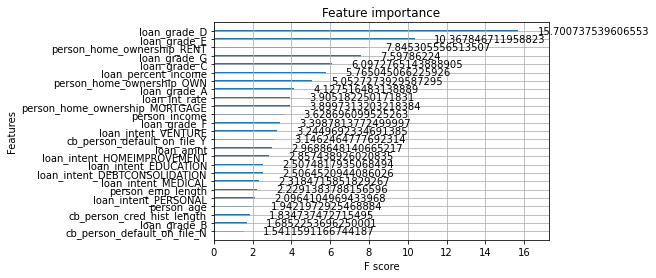

In [102]:
## Feature Importance
#ekstraks nama kolom setelah prepos
onehot_columns=model_best.best_estimator_.named_steps['prepo'].named_transformers_['categoric'].named_steps['onehot'].get_feature_names(input_features=cat_columns)
cols=np.array(list(num_columns)+list(onehot_columns))

#plot dengan nama kolom asli
model_best.best_estimator_.named_steps['algo'].get_booster().feature_names=list(cols)
plot_importance(model_best.best_estimator_.named_steps['algo'], importance_type='gain')

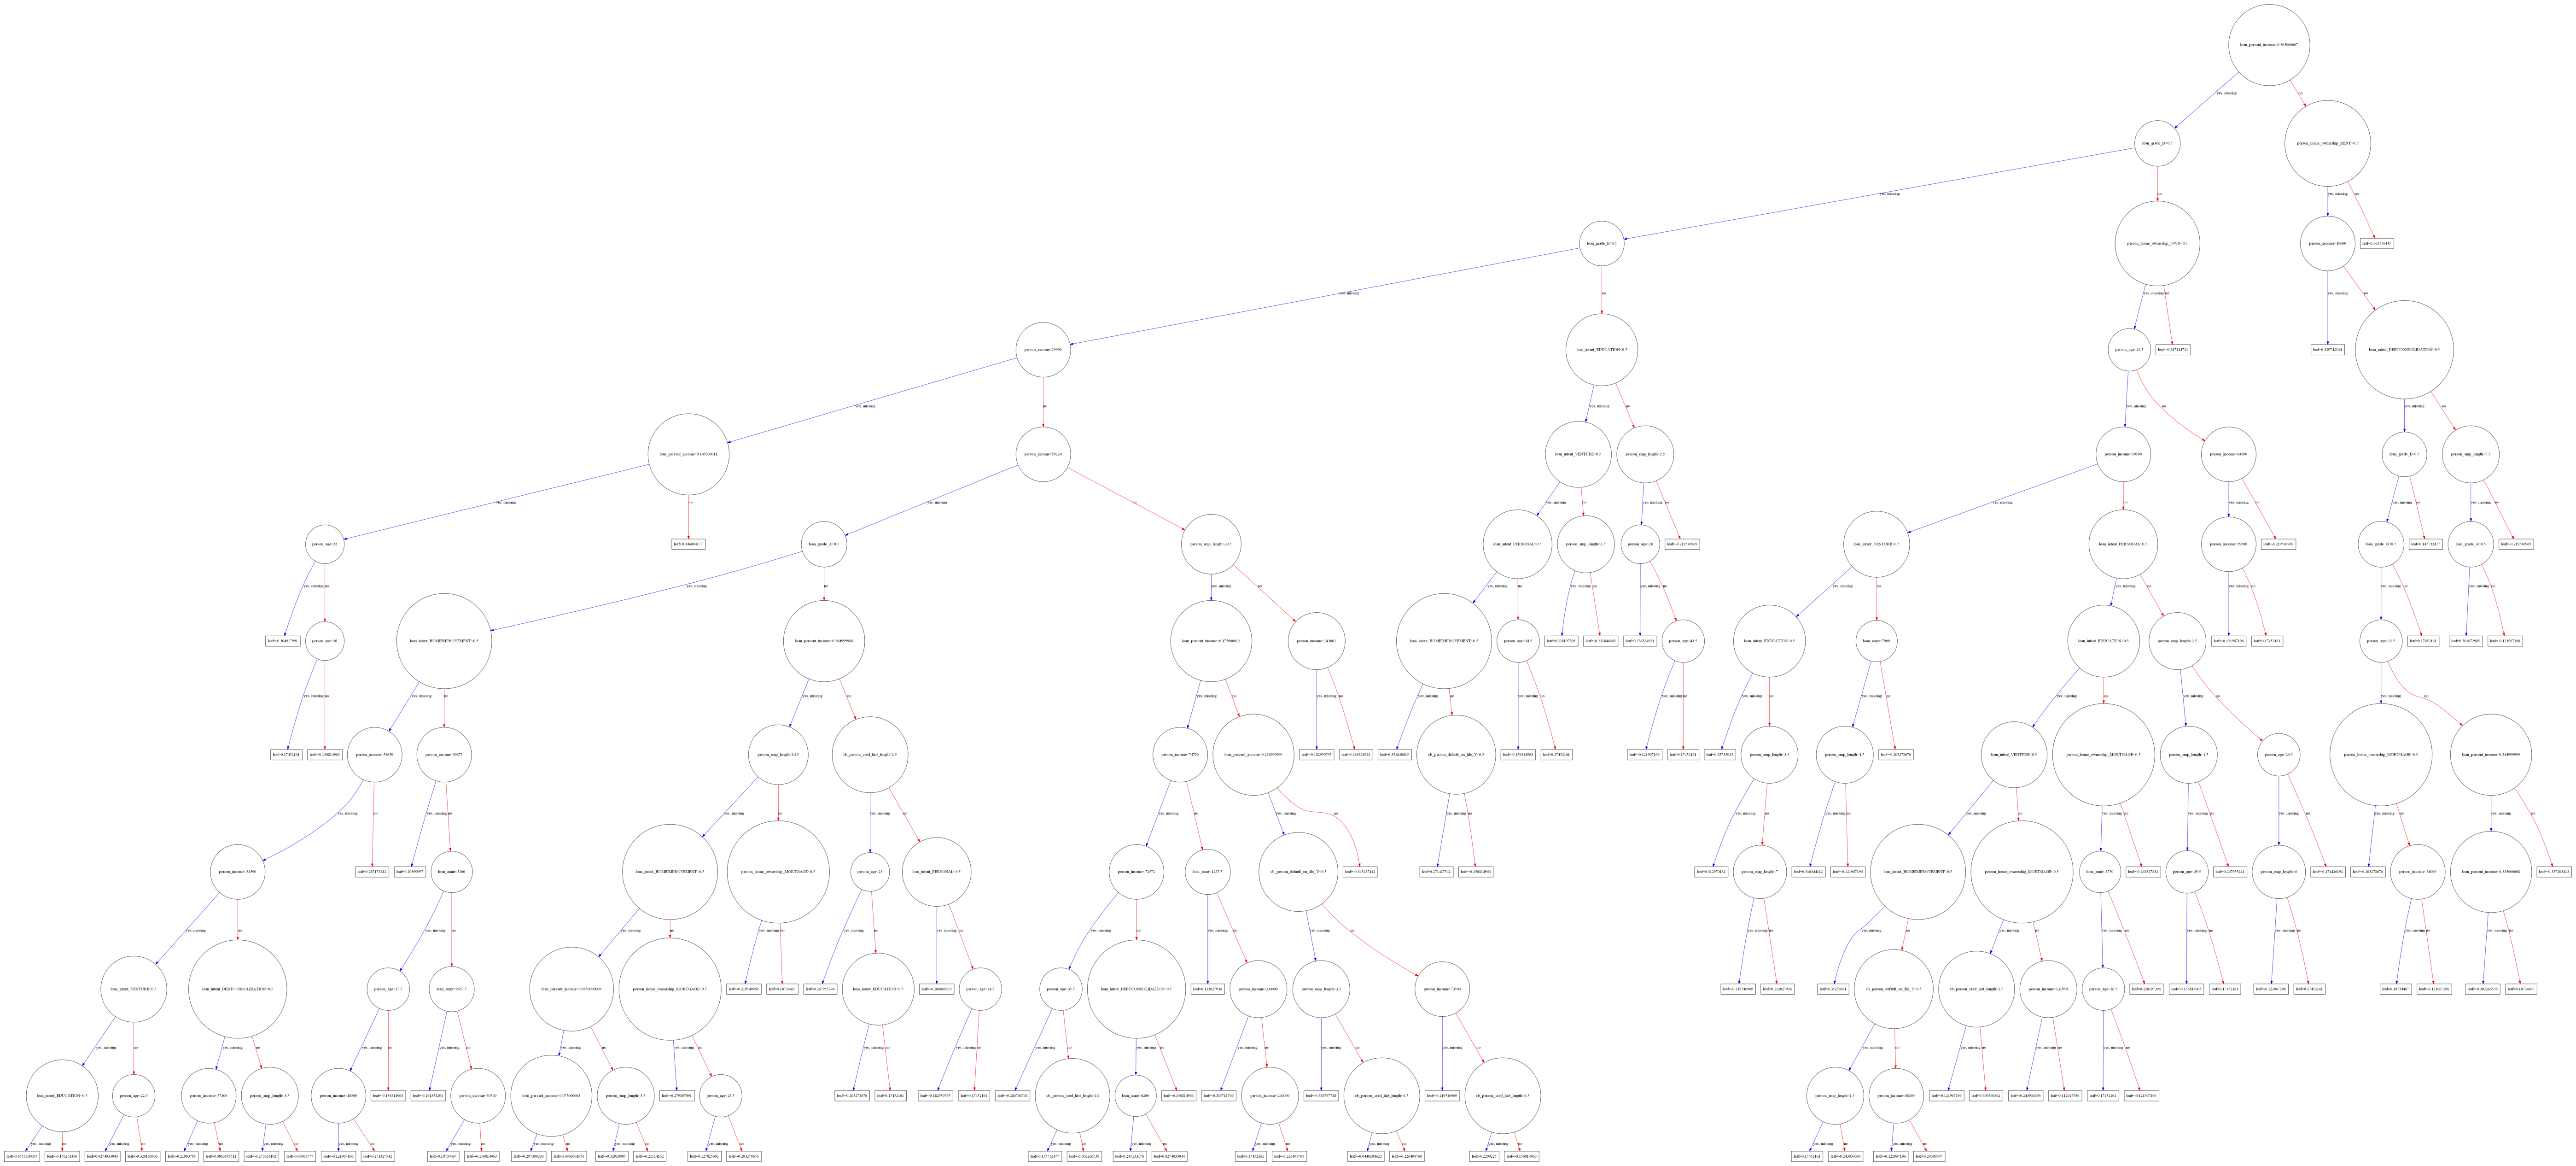

In [103]:
plot_tree(model_best.best_estimator_.named_steps['algo'])
fig=plt.gcf()
fig.set_size_inches(100,100)
plt.savefig('kaggle.png')

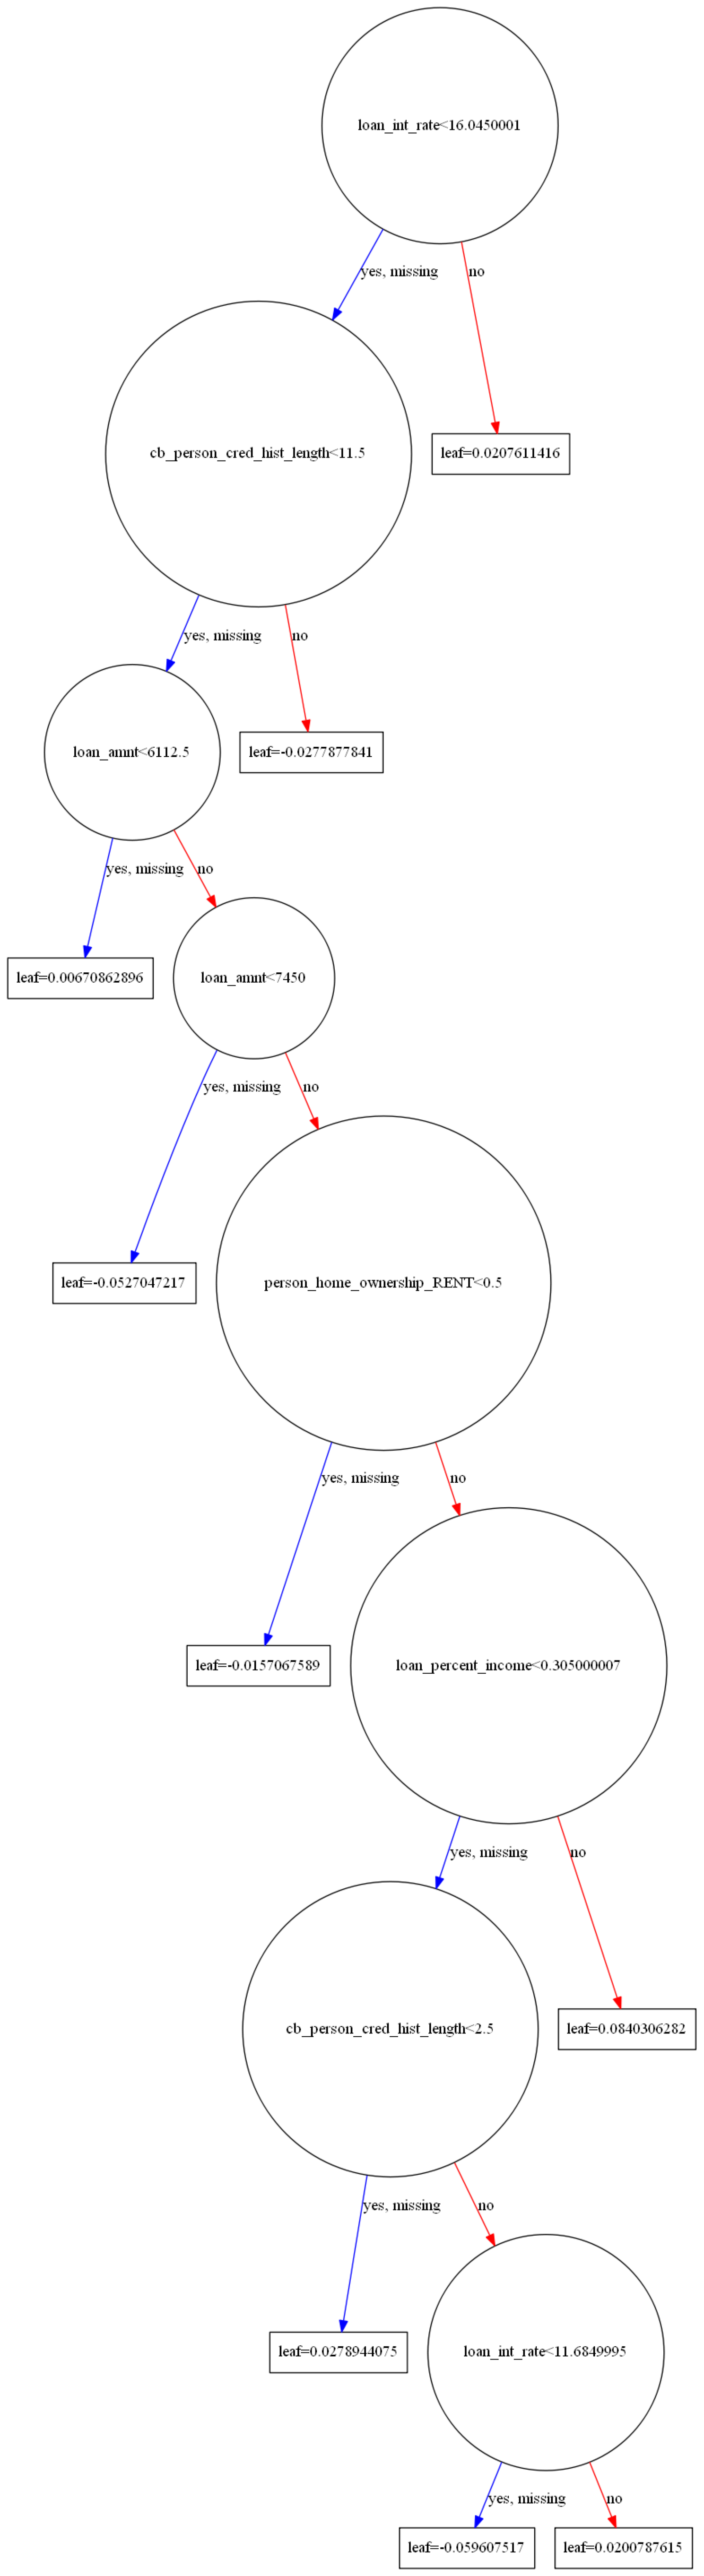

In [104]:
plot_tree(model_best.best_estimator_.named_steps['algo'], num_trees=88)
fig=plt.gcf()
fig.set_size_inches(100,100)
plt.savefig('kaggle89.png')

# Selesai, Alhamdulillah